In [90]:
import os
from pathlib import Path
import math 

import rasterio as rio
from rasterio.enums import Resampling
from rasterio.plot import show
from affine import Affine
from h3ronpy.raster import nearest_h3_resolution, raster_to_dataframe
from h3ronpy import raster
from shapely.geometry import Polygon

In [68]:
raster?

Type:        module
String form: <module 'h3ronpy.raster' from '/home/biel/miniconda3/envs/geo/lib/python3.10/site-packages/h3ronpy/raster.py'>
File:        ~/miniconda3/envs/geo/lib/python3.10/site-packages/h3ronpy/raster.py
Docstring:  
Conversion of raster numpy arrays to h3.

Resolution search modes
-----------------------

* "min_diff": chose the h3 resolution where the difference in the area of a pixel and the h3index is as small as possible.
* "smaller_than_pixel":  chose the h3 resolution where the area of the h3index is smaller than the area of a pixel.


In [3]:
base_data_path = Path("../../h3_data_importer/data/")

## Resample woodpulp dataset to match the H3 resolution 6

In [78]:
wood_pulp_harvest = "../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha.tif"
with rio.open(wood_pulp_harvest) as src:
    aff = src.transform
    bounds = src.bounds
    shape = src.shape

In [79]:
aff

Affine(0.00025000000000000163, 0.0, -60.567222596,
       0.0, -0.00025000000000000163, 0.869078994)

In [100]:
res = []
# square de pix size to get 
for scale_factor in (x for x in range(1, 400) if x%2):
    x_pix_size = aff.a * scale_factor
    y_pix_size = aff.e * scale_factor
    shape = (int((bounds.right-bounds.left)/x_pix_size), int((bounds.bottom-bounds.top)/y_pix_size))
    new_trans = Affine(x_pix_size, aff.b, aff.c, aff.d, y_pix_size, aff.f)
    h3_res = nearest_h3_resolution(shape, new_trans, search_mode="min_diff")
    res.append((scale_factor, x_pix_size, shape,  h3_res))

In [102]:
[x for x in res if x[-1] == 6][0]

(181, 0.0452500000000003, (529, 762), 6)

So ` 0.04525` deegres will be the smaller pixel size that can contain a res 6 H3 hexagon

which is `181` times bigger than the original res of `0.00025`

In [103]:
aff.a * 181

0.0452500000000003

In [105]:
!gdalwarp -q -s_srs EPSG:4326 -t_srs EPSG:4326 -r sum -tr 0.04525 0.04525 -multi -of GTiff -overwrite\
		"../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha.tif" \
		"../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha_res.tif"

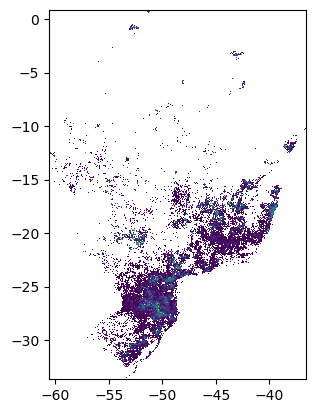

In [110]:
with rio.open("../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha_res.tif") as src:
    show(src, interpolation="none")
    df = raster_to_dataframe(src.read(1), src.transform, h3_resolution=6,nodata_value=src.nodata, compacted=False, geo=True)

<AxesSubplot:>

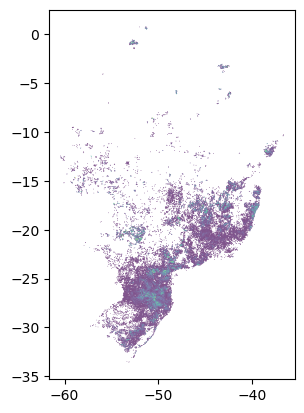

In [107]:
df.plot(column="value")

looks like successs!

In [108]:
df.to_file("../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_harvest_ha_h3.geojson", driver="GeoJSON")

In [109]:
!gdalwarp -q -s_srs EPSG:4326 -t_srs EPSG:4326 -r sum -tr 0.04525 0.04525 -multi -of GTiff\
		"../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_prod_t_nd.tif" \
		"../../h3_data_importer/data/woodpulp/gfw_plantations_woodpulp_prod_t_nd_res.tif"